# Creating a Dataset in Pytorch & Tensorflow from Disk

This example from S. Raschka books we are going to input for a model from a group of image files. They need to be resized and labelled. Also we will use the Tensorflow documentation to provide the same solution in TF.

In [1]:
import torch
import tensorflow as tf
import pathlib
from IPython.display import Image
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
%matplotlib inline

In [13]:
images_dir = pathlib.Path('./cat_dog_images')
print(images_dir)
images_list = sorted([str(path) for path in images_dir.glob('*.jpg')])
print(images_list)

cat_dog_images
['cat_dog_images\\cat-01.jpg', 'cat_dog_images\\cat-02.jpg', 'cat_dog_images\\cat-03.jpg', 'cat_dog_images\\dog-01.jpg', 'cat_dog_images\\dog-02.jpg', 'cat_dog_images\\dog-03.jpg']


Image shape: (900, 1200, 3)
Image shape: (900, 1200, 3)
Image shape: (900, 742, 3)
Image shape: (800, 1200, 3)
Image shape: (800, 1200, 3)
Image shape: (900, 1200, 3)


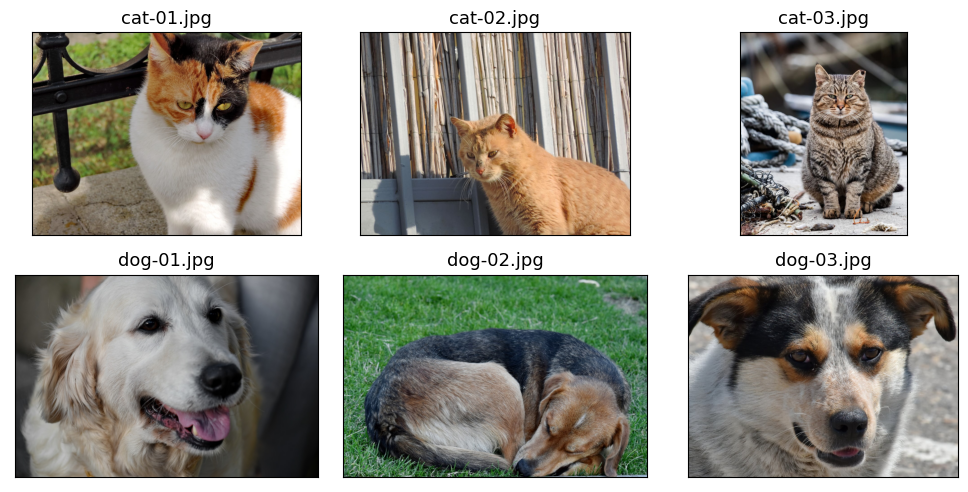

In [3]:
# Visualize Images

fig = plt.figure(figsize=(10,5))

for i,file in enumerate(images_list):
    img = Image.open(file)
    print('Image shape:', np.array(img).shape)
    ax = fig.add_subplot(2,3,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size = 13)

plt.tight_layout()
plt.show()

In [4]:
# Images need to be at the same size.
# Also the images need to be labelled, in this case 1 for dogs and 0 for cats

# Labelling

labels = [np.where('dog' in os.path.basename(file), 1, 0) for file in images_list]
print(labels)
print(type(labels))

[array(0), array(0), array(0), array(1), array(1), array(1)]
<class 'list'>


## Pytorch

In [5]:
class ImageDataset(Dataset):
    '''
    A custom Dataset class must contain the following methods to be used in the dataloader
    __init__()
    __getitem__() to return the corresponding sample to the given index
    '''
    
    def __init__(self, files_list, labels_list):
        self.files_list = files_list
        self.labels_list = labels_list
        
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, index):
        return self.files_list[index],self.labels_list[index]

In [6]:
image_dataset = ImageDataset(images_list,labels)

for file,label  in image_dataset:
    print(file, label)
    print(type(label))

cat_dog_images\cat-01.jpg 0
<class 'numpy.ndarray'>
cat_dog_images\cat-02.jpg 0
<class 'numpy.ndarray'>
cat_dog_images\cat-03.jpg 0
<class 'numpy.ndarray'>
cat_dog_images\dog-01.jpg 1
<class 'numpy.ndarray'>
cat_dog_images\dog-02.jpg 1
<class 'numpy.ndarray'>
cat_dog_images\dog-03.jpg 1
<class 'numpy.ndarray'>


Usually the images need additional transformations, resize, augmentation, rotations, scaling, decode raw content and convert the pixel arrays into tensors.

In Pytorch, such transformations can be accomplished with the torchvision module.

torchvision.transforms

https://pytorch.org/vision/stable/index.html

Transforms are common image transformations available in the torchvision.transforms module. They can be chained together using Compose. Most transform classes have a function equivalent: functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

In [7]:
import torchvision.transforms as transforms

im_height, im_width = 120, 120

# transforms resembles the structure of the Scikit-Learn methods Pipeline or make_pipeline, by grouping in a list the
# sequence of preprocessing steps.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((im_height, im_width))
])

# Update the ImageDataset to include the transform defined into the Pipeline


In [8]:
class ImageDataset(Dataset):
    '''
    A custom Dataset class must contain the following methods to be used in the dataloader
    __init__()
    __getitem__() to return the corresponding sample to the given index
    
    We add the transform / preprocessing steps into the class
    '''
    
    def __init__(self, files_list, labels_list, transform = None):
        self.files_list = files_list
        self.labels_list = labels_list
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, index):
        img = Image.open(self.files_list[index])
        if self.transform is not None:
            # Apply transforms
            img = self.transform(img)
        label = self.labels_list[index]
        return img, label

In [9]:
image_dataset = ImageDataset(images_list, labels, transform)

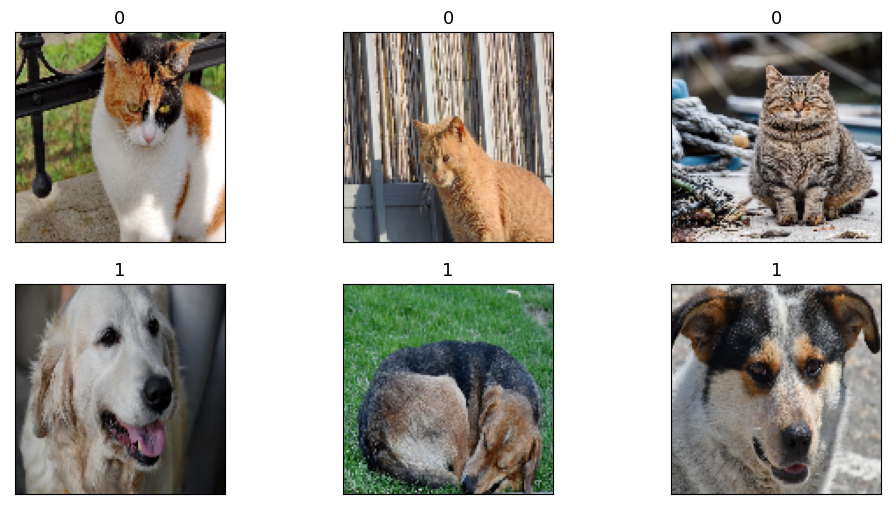

In [11]:
# Visualize the transformed images

fig = plt.figure(figsize = (12,6))

for i, sample in enumerate(image_dataset):
    ax = fig.add_subplot(2,3, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(sample[0].numpy().transpose((1,2,0)))
    ax.set_title(f'{sample[1]}', size= 13)
    

## Tensorflow

Refs:

- https://www.tensorflow.org/tutorials/load_data/images
- https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part1.ipynb



In [14]:
# The process in Tensorflow is quite similar to that one in Pytorch

# Instead of creating the ImageDataset Class, the method from_tensor_slices provides the pair

tf_files_labels = tf.data.Dataset.from_tensor_slices(
    (images_list, labels))

for item in tf_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'cat_dog_images\\cat-01.jpg' 0
b'cat_dog_images\\cat-02.jpg' 0
b'cat_dog_images\\cat-03.jpg' 0
b'cat_dog_images\\dog-01.jpg' 1
b'cat_dog_images\\dog-02.jpg' 1
b'cat_dog_images\\dog-03.jpg' 1


In [15]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [im_height, im_width])
    image /= 255.0

    return image, label

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

(120, 120, 3) 0
(120, 120, 3) 0
(120, 120, 3) 0
(120, 120, 3) 1
(120, 120, 3) 1
(120, 120, 3) 1


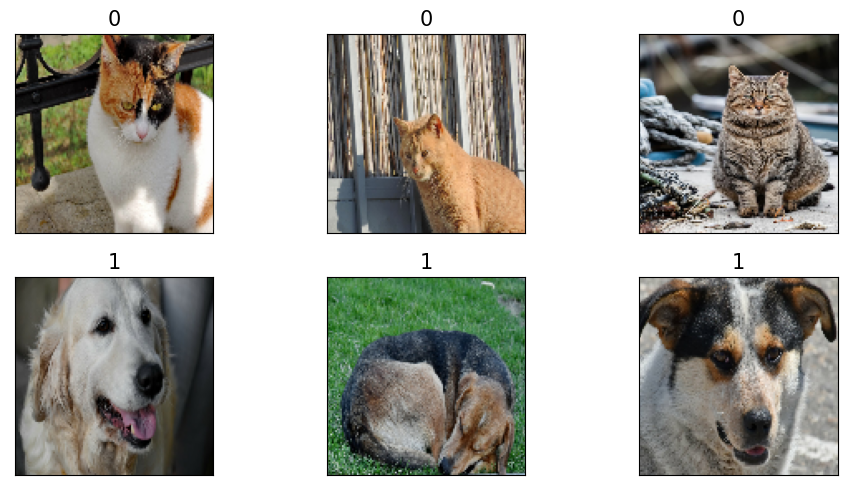

In [17]:
im_height, im_width = 120, 120

tf_images_labels = tf_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(tf_images_labels):
    print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
#plt.savefig('ch13-catdog-dataset.pdf')
plt.show()